In [1]:
import  pandas as pd
import numpy as np
import re
from collections import Counter
import nltk

In [2]:
#读取数据
dir_1 = r'all_data_new_1.csv'

df = pd.read_csv(dir_1)
print(df.shape)
df.head()

(16251, 3)


,text,title,type
0,"They stood in line at Trump Tower, sometimes u...","At Donald Trump<U+2019>s Properties, a Showcas...",1
1,Donald J. Trump <U+2019>s foundation informed ...,Trump Foundation Tells New York It Has Stopped...,1
2,President-elect Donald J. Trump won the White ...,"Donald Trump Prepares for White House Move, bu...",1
3,An investment pitch for a new Texas hotel is t...,Luring Chinese Investors With Trump<U+2019>s N...,1
4,President-elect Donald J. Trump <U+2019>s wife...,Melania and Barron Trump Won<U+2019>t Immediat...,1


In [3]:
df['type'].unique()

array([1, 0])

In [4]:
#转换数据类型
df['type'] = df['type'].astype(int)
print(df['type'][:5])

0    1
1    1
2    1
3    1
4    1
Name: type, dtype: int64


In [5]:
df['text'][12219]

'\nThis article was written by SGT Report and originally published at SGTReport.com . \nEditor<U+2019>s Comment: The web connecting the Clinton<U+2019>s to professional provocateurs who<U+2019>ve been fueling violence and riots via BlackLivesMatter and through anti-Trump campaigns runs back to a central core. These are agents of change for life, and they are willing to use any means necessary to tips the scales into something they can work with. There is every indication that the agenda is to stir social unrest and further division, and with enough fake riots and manufactured anger, things might lead to a full-fledged civil war in America. Problem. Reaction. Solution. \nLou Dobbs called for Soros to be investigated and held liable for inciting riots that are causing property damage and personal harm:\nShould DOJ investigate Soros & his links to non-profits for their role in inciting riots that have caused property damage & personal injury?\n<U+2014> Lou Dobbs (@LouDobbs) November 12, 2

**data preprocessing**

In [6]:
#去除标点等无用的符号以及停用词
def cleanlines(line,remove_stopwords=False):   
    p1=re.compile(r'-\{.*?(zh-hans|zh-cn):([^;]*?)(;.*?)?\}-')
    p2=re.compile(r'[(][: @ . , ？！\s][)]')
    p3=re.compile(r'[「『]')
    p4=re.compile(r'[\s+\.\!\/_,$%^*(+\"\')]+|[+——()?【】“”！，。？、~@#￥%……&*（）0-9 , : ; \-\ \[\ \]\ ]')
    p5=re.compile(r'[^a-zA-Z]')
    line=p1.sub(r' ',line)
    line=p2.sub(r' ',line)
    line=p3.sub(r' ',line)
    line=p4.sub(r' ',line)
    line=p5.sub(r' ',line)
    words = line.lower().split()
    if remove_stopwords:
        words = [w for w in words if w not in eng_stopwords]
    return words

In [7]:
#添加停用词表
eng_stopwords = [line.rstrip() for line in open('stop_words.txt')]
eng_stopwords[:5]

["'d", "'ll", "'m", "'re", "'s"]

In [8]:
#处理内容文本
df['text'] = df['text'].astype(str)
sents = df['text']
text_words=[cleanlines(sent,remove_stopwords=True) for sent in sents]

In [9]:
len(text_words)
print(text_words[:5])

[['stood', 'trump', 'tower', 'half', 'hour', 'handing', 'cash', 'mementos', 'president', 'elect', 'mini', 'gold', 'wrapped', 'chocolate', 'bricks', 'stamped', 'trump', 'trump', 'monogrammed', 'sweaters', 'towels', 'glassware', 'trump', 'cologne', 'bought', 'sons', 'shanon', 'loggins', 'lufkin', 'tex', 'golden', 'shopping', 'bag', 'embossed', 'trump', 'crest', 'carried', 'bottles', 'success', 'trump', 'fragrance', 'successful', 'explained', 'business', 'donald', 'trump', 'people', 'flocking', 'midtown', 'manhattan', 'skyscraper', 'dining', 'restaurants', 'buying', 'wares', 'reporters', 'fastidiously', 'chronicling', 'comings', 'goings', 'transition', 'team', 'branded', 'properties', 'providing', 'backdrop', 'television', 'live', 'shots', 'trump', 'staid', 'task', 'preparing', 'assume', 'presidency', 'exercise', 'conspicuous', 'promotion', 'carefully', 'choreographed', 'branding', 'president', 'elect', 'vast', 'real', 'estate', 'holdings', 'raising', 'questions', 'exploiting', 'profile',

In [10]:
#处理标题文本
df['title'] = df['title'].astype(str)
title_sents = df['title']
title_words=[cleanlines(sent,remove_stopwords=True) for sent in title_sents]

In [11]:
#讲内容和标题连接在一起
def concat_text(text_words,title_words):
    concat_text = []
    for i in range(len(text_words)):
        temp = text_words[i]+title_words[i]
        concat_text.append(temp)
    return concat_text

concat_text = concat_text(text_words,title_words)
        

In [12]:

len(concat_text)

16251

*build dict*

In [13]:
# set parameters:
#字典大小
vocab_size = 5000 #dict size
batch_size = 200 #batch size for each training
sequence_length = 300 #sequence length -same for every sample
embedding_dims=128 #embed dim

In [14]:
#build dic
def build_vocab(content_list,vocab_size):
    vocab_size = vocab_size
    all_vocabs = []
    for content in content_list:
        all_vocabs.extend(list(content))
    #{word:counts}
    counter = Counter(all_vocabs)
    #take the most common top 4999
    count_pairs = counter.most_common(vocab_size - 1)  #return pairs
    words, _ = list(zip(*count_pairs))    #ignore the counts
    words = ['<PAD>'] + list(words)  #防止样本数太小 填充为0 
    word_to_id = dict(zip(words, range(len(words))))  #change pos to 编号 number
    return words, word_to_id

In [15]:
words, word_to_id = build_vocab(concat_text,vocab_size)
print(word_to_id)

{'<PAD>': 0, 'trump': 1, 'clinton': 2, 'people': 3, 'hillary': 4, 'president': 5, 'election': 6, 'campaign': 7, 'time': 8, 'obama': 9, 'donald': 10, 'government': 11, 'american': 12, 'news': 13, 'political': 14, 'war': 15, 'media': 16, 'white': 17, 'republican': 18, 'russia': 19, 'country': 20, 'party': 21, 'presidential': 22, 'house': 23, 'don': 24, 'day': 25, 'america': 26, 'vote': 27, 'voters': 28, 'united': 29, 'democratic': 30, 'public': 31, 'national': 32, 'fbi': 33, 'support': 34, 'policy': 35, 'percent': 36, 'women': 37, 'law': 38, 'york': 39, 'email': 40, 'power': 41, 'times': 42, 'democrats': 43, 'washington': 44, 'told': 45, 'emails': 46, 'americans': 47, 'called': 48, 'russian': 49, 'military': 50, 'bill': 51, 'republicans': 52, 'federal': 53, 'including': 54, 'october': 55, 'change': 56, 'week': 57, 'candidate': 58, 'administration': 59, 'system': 60, 'foreign': 61, 'money': 62, 'life': 63, 'syria': 64, 'real': 65, 've': 66, 'november': 67, 'days': 68, 'security': 69, 'won

In [16]:
print(len(word_to_id))

5000


In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc ,classification_report,roc_auc_score
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from gensim.models.word2vec import Word2Vec
from zhon.hanzi import punctuation
import numpy as np
import pandas as pd
import jieba
from sklearn.externals import joblib
from sklearn.svm import SVC
import sys 
import re
import keras as kr


Using TensorFlow backend.


In [18]:
#padding the samples sequence length = 300
def get_pad_text(text_words, word_to_id, max_length=100):   
    data_id=[]
    for x in text_words:
        single_text=[]
        for i in x:
            if i in words:
                a=word_to_id[i]
                single_text.append(a)
        data_id.append(single_text)
    x_pad = kr.preprocessing.sequence.pad_sequences(data_id, max_length)
    return np.array(x_pad)

X = get_pad_text(concat_text,word_to_id,max_length=sequence_length)

In [19]:
print(X.shape)
print(X)

(16251, 300)
[[  65  823 3439 ... 1635    5  136]
 [   0    0    0 ... 1452   39 1505]
 [  56    1 2746 ...   23  177 1547]
 ...
 [   0    0    0 ...    0 1376 1667]
 [   0    0    0 ...  533  787 1667]
 [   0    0    0 ...    0    0 1667]]


In [20]:
from sklearn.model_selection import train_test_split
y = df['type'].astype(int)

**划分训练集和线下验证集**

In [21]:
x_train,x_val,y_train,y_val = train_test_split(X,y,test_size=0.2,random_state=10,stratify=y)

In [22]:
print(x_train.shape)
print(x_val.shape)
print(y_train.shape)
print(y_val.shape)
print(type(y_train))

(13000, 300)
(3251, 300)
(13000,)
(3251,)
<class 'pandas.core.series.Series'>


In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc ,classification_report,roc_auc_score
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [24]:
model = SVC(kernel='rbf',gamma='auto')
model.fit(x_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [25]:
classifier_names = ['LR','RBF SVM','Random Forest','Boosted Trees']

classifiers = [LogisticRegression(random_state=0),SVC(kernel='rbf'),
               RandomForestClassifier(max_depth=6, n_estimators=60),
               GradientBoostingClassifier(n_estimators=60, learning_rate=0.9,max_depth=5)]

In [30]:
#result to dict
import time
clf_results={}
for i,model in zip(classifier_names,classifiers):
    start = time.time()
    model.fit(x_train, y_train)
    pred_y = model.predict(x_val)
    end = time.time()
    if i == 'LR':
        pred_y = model.predict_proba(x_val) 
    clf_results[i]=pred_y
    print(i,end-start)

//anaconda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LR 0.5368537902832031


//anaconda/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


RBF SVM 253.66777968406677
Random Forest 3.8760030269622803
Boosted Trees 31.454627990722656


In [31]:
print(clf_results['RBF SVM'])
print(type(clf_results['RBF SVM']))
print(clf_results['LR'])
LR_2 = []
for i in range(0,len(clf_results['LR'])):
    LR_2.append(clf_results['LR'][i][1])
LR_2 = np.array(LR_2)
print(LR_2)


[0 0 0 ... 0 0 0]
<class 'numpy.ndarray'>
[[0.43559114 0.56440886]
 [0.85776015 0.14223985]
 [0.84071932 0.15928068]
 ...
 [0.6124656  0.3875344 ]
 [0.7561944  0.2438056 ]
 [0.68688107 0.31311893]]
[0.56440886 0.14223985 0.15928068 ... 0.3875344  0.2438056  0.31311893]


In [32]:
dir_2 = r'result_new.csv'

predict_result = pd.read_csv(dir_2)
predict_result.head()

,predict,label
0,9.999269e-01,1
1,5.034981e-06,0
2,7.942072e-11,0
3,2.241843e-08,0
4,5.556067e-05,0


In [33]:
predict_result['svm'] = clf_results['RBF SVM']
predict_result['LR'] = LR_2

In [34]:
predict_result.tail()

,predict,label,svm,LR
3246,9.999498e-01,1,0,0.558450
3247,3.657237e-07,0,0,0.608247
3248,3.425474e-10,0,0,0.387534
3249,9.999607e-01,1,0,0.243806
3250,4.565080e-08,0,0,0.313119


In [53]:
predict_result['final_result'] = 0.1 * predict_result['svm'] + 0.9 * predict_result['predict']
predict_result.head()

,predict,label,svm,LR,final_result,final_result_lr
0,9.999269e-01,1,0,0.564409,8.999342e-01,0.825720
1,5.034981e-06,0,0,0.142240,4.531483e-06,0.056899
2,7.942072e-11,0,0,0.159281,7.147865e-11,0.063712
3,2.241843e-08,0,0,0.034366,2.017659e-08,0.013746
4,5.556067e-05,0,0,0.414768,5.000461e-05,0.165941


In [54]:
result = np.array(predict_result['final_result'])
print(result)
print(type(result))
def Chang_(pred):
    results = []
    for i in range(len(pred)):
        if pred[i]>0.5:
            temp = 1
            results.append(temp)
        else:
            temp = 0
            results.append(temp)
    return results
        
results = Chang_(result)

from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_val, results))


[8.99934232e-01 4.53148318e-06 7.14786480e-11 ... 3.08292691e-10
 8.99964595e-01 4.10857236e-08]
<class 'numpy.ndarray'>
[[2266    4]
 [  27  954]]


In [55]:
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score

print('precision:',precision_score(y_val, results))
print('recall:',recall_score(y_val, results))
print('f1:',f1_score(y_val, results))
print('-========')

precision: 0.9958246346555324
recall: 0.9724770642201835
f1: 0.9840123775141827
-========


In [56]:
y_scores = pd.DataFrame(results)[0].values
print(y_scores)

[1 0 0 ... 0 1 0]


In [39]:
auc_value = roc_auc_score(y_val, y_scores)
print(auc_value)

0.9863768428332144


In [61]:
#freq-LR + TEXTCNN
predict_result['final_result_lr'] = 0.4 * predict_result['LR'] + 0.6 * predict_result['predict']
predict_result.head()

,predict,label,svm,LR,final_result,final_result_lr
0,9.999269e-01,1,0,0.564409,8.999342e-01,0.825720
1,5.034981e-06,0,0,0.142240,4.531483e-06,0.056899
2,7.942072e-11,0,0,0.159281,7.147865e-11,0.063712
3,2.241843e-08,0,0,0.034366,2.017659e-08,0.013746
4,5.556067e-05,0,0,0.414768,5.000461e-05,0.165941


In [62]:
result = np.array(predict_result['final_result_lr'])
print(result)
print(type(result))
def Chang_(pred):
    results = []
    for i in range(len(pred)):
        if pred[i]>0.5:
            temp = 1
            results.append(temp)
        else:
            temp = 0
            results.append(temp)
    return results
        
results = Chang_(result)

from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_val, results))


[0.8257197  0.05689896 0.06371227 ... 0.15501376 0.69749863 0.1252476 ]
<class 'numpy.ndarray'>
[[2268    2]
 [  26  955]]


In [63]:
y_scores = pd.DataFrame(results)[0].values
print(y_scores)

[1 0 0 ... 0 1 0]


In [64]:
auc_value = roc_auc_score(y_val, y_scores)
print(auc_value)

0.986307687471653


In [44]:
from sklearn.metrics import confusion_matrix

for i in clf_results.keys():
    print(i,confusion_matrix(y_val, clf_results[i]))
    print('-========')

ValueError: Classification metrics can't handle a mix of binary and continuous-multioutput targets

In [67]:
from sklearn.metrics import precision_score, recall_score
# f1 score
from sklearn.metrics import f1_score
for i in clf_results.keys():
    print('precision:',i,precision_score(y_val, clf_results[i]))
    print('recall:',i,recall_score(y_val, clf_results[i]))
    print('f1:',i,f1_score(y_val, clf_results[i]))
    print('-========')

precision: LR 0.6002906976744186
recall: LR 0.42099898063200814
f1: LR 0.49490713001797476
-========
precision: RBF SVM 1.0
recall: RBF SVM 0.0050968399592252805
f1: RBF SVM 0.010141987829614604
-========
precision: Random Forest 0.7898423817863398
recall: Random Forest 0.4597349643221203
f1: Random Forest 0.5811855670103093
-========
precision: Boosted Trees 0.9749455337690632
recall: Boosted Trees 0.9123343527013251
f1: Boosted Trees 0.9426013691416535
-========


In [68]:
y_scores = {}
for i in clf_results.keys():
    y_scores[i] = pd.DataFrame(clf_results[i])[0].values
print(y_scores)


{'LR': array([1, 0, 0, ..., 0, 0, 0]), 'RBF SVM': array([0, 0, 0, ..., 0, 0, 0]), 'Random Forest': array([1, 0, 0, ..., 0, 0, 0]), 'Boosted Trees': array([1, 0, 0, ..., 0, 1, 0])}


In [69]:
auc_value = {}
for i in clf_results.keys():
    auc_value[i] = roc_auc_score(y_val, y_scores[i])
print(auc_value)

{'LR': 0.6499268030913344, 'RBF SVM': 0.5025484199796126, 'Random Forest': 0.7034357640993861, 'Boosted Trees': 0.9511010970555084}


In [71]:
def train_dev_split(X,y):
    #每次的随机都保证一样
    np.random.seed(10)
    shuffle_indices = np.random.permutation(len(y))
    x_shuffled = X[shuffle_indices]
    y_shuffled = y[shuffle_indices]
    # Split train/test set
    # 后10%作为验证集
    dev_sample_index = -1 * int(0.1 * float(len(y)))
    x_train, x_dev = x_shuffled[:dev_sample_index], x_shuffled[dev_sample_index:]
    y_train, y_dev = y_shuffled[:dev_sample_index], y_shuffled[dev_sample_index:]
    print("Train/Dev split: {:d}/{:d}".format(len(y_train), len(y_dev)))
    return x_train, y_train, word_to_id, x_dev, y_dev

In [72]:
y = np.array(df['type'])
x_train, y_train, word_to_id, x_dev, y_dev = train_dev_split(X,y)

Train/Dev split: 14626/1625


**TextCNN 模型**

In [73]:
#Inputs:Input函数只需要填写列数
comment_seq = Input(shape=[sequence_length],name='x_seq')  #shape is (number of samples eg:10000,300) 
print(comment_seq.shape)
#embedding layers
embedding_layer = Embedding(len(word_to_id), embedding_dims)(comment_seq)   #填充层，Embedding(len(word_to_id), embedding_dims) 内置 5000(len word_to_id) 0....4999*128 random vector
# comment_seq 放入变成 10000*300*128
print(embedding_layer.shape)

(?, 300)
(?, 300, 128)


In [74]:
#在原来的基础上添加一个维度，相当于 类似图片数据(number sequence,r,g,b) 二维精度高 考虑了前后
'''Reshape Layer'''
reshape = Reshape(target_shape=(sequence_length, embedding_dims, 1), name='reshape')(embedding_layer) # chanels last
print(reshape.shape)
print("Builded Reshape Layer...")

(?, 300, 128, 1)
Builded Reshape Layer...


In [75]:
#使用三种filter进行过滤，将最后的结果flatten  text 只能上下移动 filter
nb_filters = 100   
filter_lengths = [3, 4, 5]   # 3*128 , 4*128, 5*128
flatten_ = []

for i in filter_lengths:
    model_internal = Sequential()
    model_internal.add(Convolution2D(nb_filters, (i, embedding_dims), activation="relu", name='conv2d_' + str(i), input_shape=(sequence_length, embedding_dims, 1)))
# chanels last,默认了strides=(1,1), padding='valid'
    model_internal.add(MaxPooling2D(pool_size=(sequence_length - i + 1, 1), name='maxpool2d_' + str(i)))
    model_internal.add(Flatten())   #flatten 去除刚刚加的最后的一纬
    flatten = model_internal(reshape)  
    #print(flatten.shape)
    flatten_.append(flatten)   #list of 三个矩阵

In [76]:
#Fully Connect Layer & Dropout Layer
dropout_rate = 0.5   
hidden_nodes = 256   
merge = concatenate(flatten_, axis=-1)    

fully_connect = Dense(hidden_nodes, activation='relu', name='fully_connect')(merge) 
dropout = Dropout(dropout_rate, name='dropout')(fully_connect)

print("Builded Fully Connect Layer & Dropout Layer...")

'''Projection Layer & Output Layer'''

output = Dense(1, activation='sigmoid', name='output')(dropout) # output layer

print("Builded  Output Layer...")

Builded Fully Connect Layer & Dropout Layer...
Builded  Output Layer...


In [77]:
model = Model([comment_seq],output)

In [78]:
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy']) #binary classification

In [79]:
from keras.callbacks import EarlyStopping,ModelCheckpoint

es = EarlyStopping(monitor='val_acc',patience=5)  #val patience times

filepath="weights.bests.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True,mode='max')
callbacks_list = [es,checkpoint]

In [80]:
model.fit(x_train, y_train,
          validation_split=0.1,
          batch_size=batch_size,   
          callbacks=[es],
          epochs=5,
          shuffle=True)

Train on 13163 samples, validate on 1463 samples
Epoch 1/5
13163/13163 [==============================] - 105s 8ms/step - loss: 0.3680 - acc: 0.8303 - val_loss: 0.0326 - val_acc: 0.9911
Epoch 2/5
13163/13163 [==============================] - 97s 7ms/step - loss: 0.0229 - acc: 0.9925 - val_loss: 0.0223 - val_acc: 0.9904
Epoch 3/5
13163/13163 [==============================] - 101s 8ms/step - loss: 0.0048 - acc: 0.9991 - val_loss: 0.0268 - val_acc: 0.9897
Epoch 4/5
13163/13163 [==============================] - 84s 6ms/step - loss: 8.7358e-04 - acc: 1.0000 - val_loss: 0.0316 - val_acc: 0.9897
Epoch 5/5
13163/13163 [==============================] - 86s 7ms/step - loss: 3.7535e-04 - acc: 1.0000 - val_loss: 0.0333 - val_acc: 0.9897


In [81]:
pred_y = model.predict(x_dev)

In [82]:
def Chang_(pred):
    results = []
    for i in range(len(pred)):
        if pred[i]>0.5:
            temp = 1
            results.append(temp)
        else:
            temp = 0
            results.append(temp)
    return results
        
results = Chang_(pred_y)

In [83]:
len(results)

1625

In [84]:
len(y_dev)

1625

In [85]:

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score

In [86]:
# Compute confusion matrix
con_matrix = confusion_matrix(results, y_dev,labels=[0,1])  # 生成混淆矩阵
print(con_matrix)

[[1151    6]
 [   3  465]]


In [87]:
print('precision:',precision_score(y_dev, results))
print('recall:',recall_score(y_dev, results))
print('f1:',f1_score(y_dev, results))

precision: 0.9935897435897436
recall: 0.9872611464968153
f1: 0.9904153354632588


In [88]:
y_scores = pd.DataFrame(pred_y)[0].values
print(y_scores[:2])

[9.999826e-01 8.412799e-05]


In [97]:
print(classification_report(y_dev, results))
auc_value = roc_auc_score(y_dev, y_scores)

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1154
           1       0.99      0.99      0.99       471

   micro avg       0.99      0.99      0.99      1625
   macro avg       0.99      0.99      0.99      1625
weighted avg       0.99      0.99      0.99      1625



In [90]:
import matplotlib.pyplot as plt
%matplotlib inline

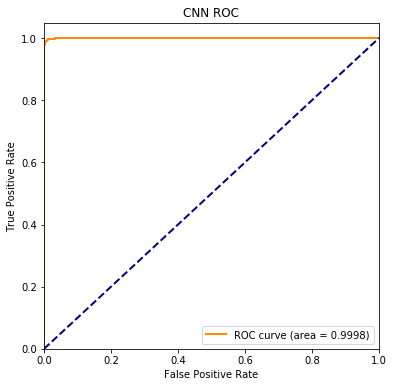

In [92]:
fpr, tpr, thresholds = roc_curve(y_dev, y_scores, pos_label=1.0)
plt.figure(figsize=(6,6))
lw = 2
plt.plot(fpr, tpr, color='darkorange', linewidth=lw, label='ROC curve (area = %0.4f)' % auc_value)
plt.plot([0, 1], [0, 1], color='navy', linewidth=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('CNN ROC')
plt.legend(loc="lower right")

In [ ]:
text_new = 'WASHINGTON — The Trump administration pushed a $1.5 trillion tax cut through Congress in 2017 on the promise that it would spark sustained economic growth. While the tax cuts have goosed the economy in the short term, officials now concede they will not be enough to deliver the 3 percent annual growth the president promised over the long term.To produce that average growth rate for the next decade, White House forecasters say, the American economy would need additional rollbacks in labor regulations, a $1 trillion infrastructure plan and another round of tax cuts.Getting all those policies implemented would be highly unlikely, given a divided Congress and a ballooning federal deficit, which could limit lawmakers’ appetite to spend money on a new tax cut or infrastructure plan.But without those additional steps, the president’s economic team predicts in a report released on Tuesday that growth would slow to about 2 percent a year in 2026. That is the year when many of the individual tax cuts included in the 2017 law are set to expire, essentially producing a tax increase for millions of Americans.'

In [ ]:
text_words_new=[cleanlines(text_new,remove_stopwords=True)]


In [ ]:
print(text_words_new[0])

In [ ]:
X_new = get_pad_text(text_words_new,word_to_id,max_length=sequence_length)
print(X_new.shape)

In [ ]:
X_new

In [ ]:
model.predict(X_new)

In [ ]:
dir_2 = r'New_Data.csv'
test_set = pd.read_csv(dir_2)
test_set = test_set[['title','content','label']]
test_set.head()

In [ ]:
test_set['label'] = test_set['label'].astype(int)


In [ ]:
test_set['content'] = test_set['content'].astype(str)
sents = test_set['content']
text_words=[cleanlines(sent,remove_stopwords=True) for sent in sents]
print(text_words[:5])

In [ ]:
test_set['title'] = test_set['title'].astype(str)
sents = test_set['title']
title_words=[cleanlines(sent,remove_stopwords=True) for sent in sents]
print(title_words[:5])

In [ ]:
def concat_text(text_words,title_words):
    concat_text = []
    for i in range(len(text_words)):
        temp = text_words[i]+title_words[i]
        concat_text.append(temp)
    return concat_text
concat_text = concat_text(text_words,title_words)

In [ ]:
X = get_pad_text(concat_text,word_to_id,max_length=sequence_length)

In [ ]:
y = np.array(test_set['label'])


In [ ]:
pred_y = model.predict(X)
test_set['predict'] = pred_y
print(test_set.head())
test_set.to_csv(r'1.csv',header=True, index=False)


In [ ]:
def Chang_(pred):
    results = []
    for i in range(len(pred)):
        if pred[i]>0.5:
            temp = 1
            results.append(temp)
        else:
            temp = 0
            results.append(temp)
    return results
        
results = Chang_(pred_y)

In [ ]:
con_matrix = confusion_matrix(results, y,labels=[0,1])  # 生成混淆矩阵
print(con_matrix)

In [ ]:
print('precision:',precision_score(y, results))
print('recall:',recall_score(y, results))
print('f1:',f1_score(y, results))